# Feature Detection

In [1]:
# import methods from FIA python script
from FIA import *
import os

# Logging
oms.LogConfigHandler().setLogLevel("ERROR")

## Library Preparation

In [2]:
# set path to your mzML files and workfolder
data_dir = "../data/example data/exampleA_ecolistrains"
run_dir = "../runs/exampleA"

data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# clean_dir(run_dir)

In [3]:
# centroid_dir = centroid_batch(data_dir, run_dir, file_ending=".mzXML")
centroid_dir = os.path.join(run_dir, "centroids")

In [4]:
# merge_dir = merge_batch(centroid_dir, run_dir, file_ending=".mzML")           # Replaced by retention time alignment

## Targeted

In [5]:
run_dir_targeted = run_dir + "_targeted"
centroid_dir_targeted = os.path.join(run_dir_targeted, "centroids")

- mz_window: window in ppm
- rt_window: in seconds
- peak_widtth: expected elution peak in seconds
- n_isotopes: Number of isotopes to include in each assay

In [26]:
def define_metabolite_table(path_to_library_file:str, mass_range:list) -> list:
    """
    Read tsv file and create list of FeatureFinderMetaboIdentCompound
    """
    metabo_table = []
    df = pd.read_csv(path_to_library_file, quotechar='"', sep="\t")
    df.apply(lambda row: 
        metabo_table.append(
                    oms.FeatureFinderMetaboIdentCompound(
                        row["CompoundName"], row["SumFormula"], row["Mass"],
                        list(map(int, row["Charge"][1:-1].split(","))), 
                        list(map(float, row["RetentionTime"][1:-1].split(","))),
                        list(map(float, row["RetentionTimeRange"][1:-1].split(","))),
                        list(map(float, row["IsotopeDistribution"][1:-1].split(",")))
                    )
                ) 
    , axis=1)

    metabo_table = [m for m in metabo_table if in1d(m.getCharges(), [0]*len(m.getCharges()))]

    return metabo_table

In [27]:
mt = define_metabolite_table("../databases/compounds_merged.tsv", [0.0, 10000.0])
len(mt)

38776

In [28]:
fm = feature_detection_targeted(os.path.join(centroid_dir, "mg1655_P3-A8_pos.mzML"), mt, mz_window=10.0, rt_window=200.0, peak_width=6.0)

RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 0 feature candidates in total.
0 features left after selection of best candidates.
No features left after filtering.


In [9]:
60 /60 /60 * (len(mt) / 10000) * 6

1.0569833333333332

In [76]:
feature_maps = targeted_features_detection(centroid_dir, run_dir_targeted, file_ending=".mzXML", compound_library_file="../databases/compounds_merged.tsv", 
                                           mz_window=10.0, rt_window=200.0, peak_width=6.0,
                                           mass_range=[0.0, 10000.0])

Defining metabolite table...


ValueError: could not convert string to float: '{0}'

In [75]:
sum([1 for f in fm])

280

## Untargeted

In [5]:
"""
feature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", 
                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,
                                            charge_lower_bound=1, charge_upper_bound=3, 
                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",
                                            mz_scoring_by_elements="false", report_convex_hulls="true")
"""

'\nfeature_maps = untargeted_features_detection(centroid_dir, run_dir, ".mzML", \n                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,\n                                            charge_lower_bound=1, charge_upper_bound=3, \n                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",\n                                            mz_scoring_by_elements="false", report_convex_hulls="true")\n'

In [7]:
feature_maps = read_feature_maps_XML(os.path.join(run_dir, "features"))

Reading in feature maps:


100%|██████████| 6/6 [00:20<00:00,  3.46s/it]


In [8]:
feature_maps_pol = assign_feature_maps_polarity(feature_maps)

Assign polarity to feature maps:


100%|██████████| 6/6 [00:00<00:00, 16.68it/s]


In [9]:
feature_maps_pos, feature_maps_neg = separate_feature_maps_pos_neg(feature_maps=feature_maps_pol)

Separating feature maps:


100%|██████████| 6/6 [00:00<00:00, 814.51it/s]


### Unlabeled

adducts to expect: 
- elements, charge and probability separated by colon
the total probability of all charged adducts needs to be 1
- e.g. positive mode:
    - proton dduct "H:+:0.6", sodium adduct "Na:+:0.4" and neutral water loss "H-2O-1:0:0.2"
- e.g. negative mode:
    - with neutral formic acid adduct: "H-1:-:1", "CH2O2:0:0.5"
- multiples don't need to be specified separately:
    - e.g. [M+H2]2+ and double water loss will be detected as well!
- optionally, retention time shifts caused by adducts can be added
    - e.g. a formic acid adduct causes 3 seconds earlier elution "CH2O2:0:0.5:-3"


Compute a zero-charge feature map from a set of charged features. 
Find putative ChargePairs, then score them and hand over to ILP.

In [15]:
pos_adducts = [b"H:+:0.6", b"K:+:0.1", b"Na:+:0.1", b"NH4:+:0.1", b"H-1O-1:+:0.05", b"H-3O-2:+:0.05"]
feature_maps_pos_adducts = detect_adducts(feature_maps_pos, potential_adducts=pos_adducts, q_try="feature", mass_max_diff=10.0, unit="ppm", max_minority_bound=2, verbose_level=3)
store_feature_maps(feature_maps_pos_adducts, "../runs/exampleA/adduct_features", ".mzML")

Detecting adducts:


  0%|          | 0/3 [00:00<?, ?it/s]

MassExplainer table size: 246


 67%|██████▋   | 2/3 [01:56<00:58, 58.38s/it]

MassExplainer table size: 246


100%|██████████| 3/3 [02:35<00:00, 49.82s/it]

MassExplainer table size: 246


100%|██████████| 3/3 [02:35<00:00, 51.91s/it]


Storing feature maps:


100%|██████████| 3/3 [00:21<00:00,  7.27s/it]


In [17]:
neg_adducts = [b"H-1:-:0.6", b"H-3O-1:-:0.2", b"Cl:-:0.1", b"Na-1:-:0.05", b"K-1:-:0.025", b"Br:-:0.025"]
feature_maps_neg_adducts = detect_adducts(feature_maps_neg, potential_adducts=neg_adducts, q_try="feature", mass_max_diff=10.0, unit="ppm", max_minority_bound=2, verbose_level=3)
store_feature_maps(feature_maps_neg_adducts, "../runs/exampleA/adduct_features", ".mzML")

Detecting adducts:


 33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]

MassExplainer table size: 364


100%|██████████| 3/3 [00:04<00:00,  1.22s/it]

MassExplainer table size: 364
MassExplainer table size: 364


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Storing feature maps:


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


In [18]:
feature_maps_pos_algn = align_retention_times(feature_maps_pos_adducts, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=10.0,
                                                mz_unit="ppm")
store_feature_maps(feature_maps_pos_algn, "../runs/exampleA/final_features", ".mzML")

feature_maps_neg_algn = align_retention_times(feature_maps_neg_adducts, 
                                                max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                                max_mz_difference=10.0,
                                                mz_unit="ppm")
store_feature_maps(feature_maps_neg_algn, "../runs/exampleA/final_features", ".mzML")

Searching feature map with larges number of features:
Aligning retention times:


100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


Storing feature maps:


100%|██████████| 3/3 [00:19<00:00,  6.33s/it]


Searching feature map with larges number of features:
Aligning retention times:


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


Storing feature maps:


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


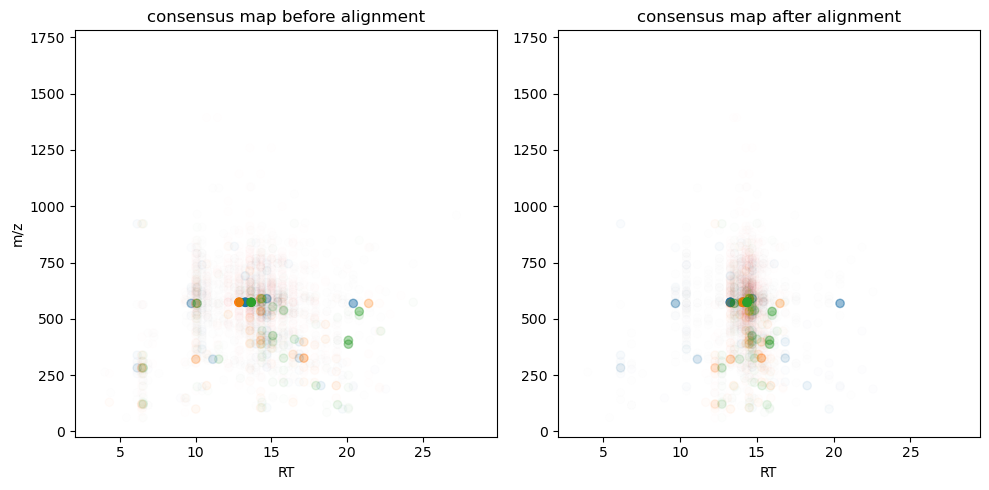

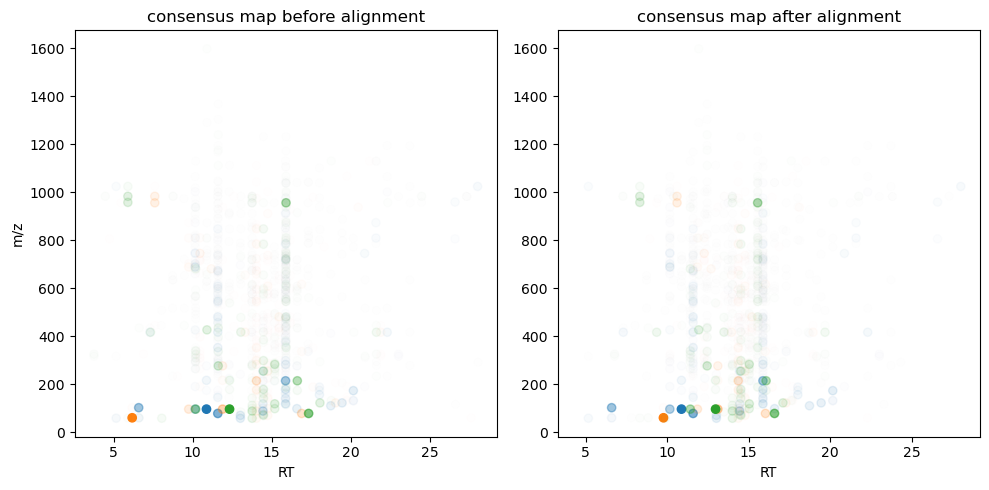

In [19]:
plot_feature_map_rt_alignment(feature_maps_pos_algn)
plot_feature_map_rt_alignment(feature_maps_neg_algn)

## Consensus building

In [20]:
consensus_map_pos = consensus_features_linking(feature_maps_pos_adducts, feature_grouper="KD")
consensus_map_pos = assign_feature_maps_polarity([consensus_map_pos], "positive")[0]
consensus_map_neg = consensus_features_linking(feature_maps_neg_adducts, feature_grouper="KD")
consensus_map_neg = assign_feature_maps_polarity([consensus_map_neg], "negative")[0]

Assign polarity to feature maps:Progress of 'computing RT transformations':

-- done [took 0.31 s (CPU), 0.32 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.64 s (CPU), 0.65 s (Wall)] -- 


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]

Progress of 'computing RT transformations':
-- done [took 0.04 s (CPU), 0.04 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.07 s (CPU), 0.07 s (Wall)] -- 


Assign polarity to feature maps:


100%|██████████| 1/1 [00:00<00:00, 80.33it/s]


In [21]:
cm_pos_df = consensus_map_to_df(consensus_map_pos)
filtered_cm_pos_df = filter_consensus_map_df(cm_pos_df, max_missing_values=1, min_feature_quality=sorted(cm_pos_df["quality"], reverse=True)[1000])
imputed_cm_pos_df = impute_consensus_map_df(filtered_cm_pos_df, n_nearest_neighbours=2)

cm_neg_df = consensus_map_to_df(consensus_map_neg)
filtered_cm_neg_df = filter_consensus_map_df(cm_neg_df, max_missing_values=1, min_feature_quality=sorted(cm_neg_df["quality"], reverse=True)[1000])
imputed_cm_neg_df = impute_consensus_map_df(filtered_cm_neg_df, n_nearest_neighbours=2)

In [31]:
sorted(cm_pos_df["quality"], reverse=True)

1.5428200464227757

## Labeling

In [22]:
mass_search_pos_df = accurate_mass_search(consensus_map_pos, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="positive")
mass_search_neg_df = accurate_mass_search(consensus_map_neg, "../databases/HMDB/", "../runs/exampleA/tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="negative")

In [23]:
id_pos_df = annotate_consensus_map_df(imputed_cm_pos_df, mass_search_pos_df, "../runs/tr1/results/result_pos.tsv")
id_neg_df = annotate_consensus_map_df(imputed_cm_neg_df, mass_search_neg_df, "../runs/tr1/results/result_neg.tsv")

In [26]:
id_pos_df

,RT,mz,quality,nissle_P3-H7_pos.mzML,mg1655_P3-A8_pos.mzML,tue1_P3-C6_pos.mzML,identifications
0,10.383417,310.309916,0.000465,1.507601e+06,1.456478e+06,1.447214e+06,N-Hexadecanoylpyrrolidine;Geranylcitronellol;P...
1,15.065993,573.182770,0.000393,7.785816e+04,4.629337e+04,5.225305e+04,nan
2,14.778569,519.326621,0.000219,1.948768e+05,2.317217e+05,2.230709e+05,"1,3-Octanediol, 9CI, 8CI; (R)-form, 1-O-[b-D-A..."
3,13.808520,735.490374,0.000242,2.516750e+05,3.635802e+05,1.548383e+05,"DG(20:3(5Z,8Z,11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z)..."
4,15.103097,485.264395,0.000251,1.168337e+05,1.197142e+05,1.230867e+05,Cepagenin;12-Ketoporrigenin;Neoporrigenin B;Le...
...,...,...,...,...,...,...,...
996,14.854018,731.411648,0.000252,0.000000e+00,0.000000e+00,7.779733e+04,nan
997,14.364102,669.415172,0.000283,0.000000e+00,0.000000e+00,1.335085e+05,Carnocin U I49
998,14.690789,455.252619,0.000279,0.000000e+00,0.000000e+00,1.156229e+05,"Lagerstroemine;5,8-Epoxy-5,8-dihydro-10'-apo-b..."
999,14.200873,673.321278,0.000217,0.000000e+00,0.000000e+00,1.400636e+05,nan


In [24]:
plot_id_df(id_pos_df)
plot_id_df(id_neg_df)

#### From mass, charge & retention time